# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Ideas

* Scale up number of samples for each class by adding additional transformations for underrepresented classes
* Mean scaling - make a mean image and subtract that (per pixel and colour)
* translate
* stretch/zoom
* blur
* noise

In [1]:
import tensorflow as tf
import numpy as np
from scipy import ndimage
import random
import skimage

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
X_train.shape

(34799, 32, 32, 3)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

38    Keep right
Name: SignName, dtype: object


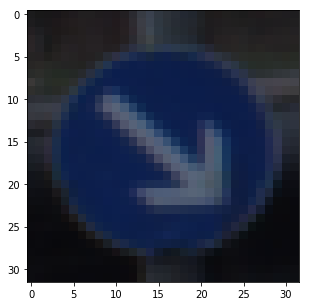

In [6]:
import random
import pandas as pd
names_df = pd.read_csv('./signnames.csv')
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(5,5))
plt.imshow(image, cmap="gray")
#print(y_train[index])
print(names_df[names_df["ClassId"]==y_train[index]].SignName)

7    Speed limit (100km/h)
Name: SignName, dtype: object


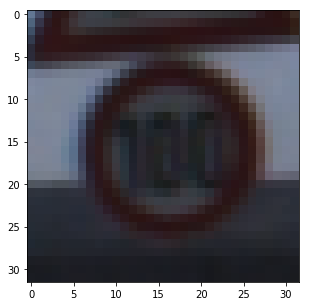

In [7]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(5,5))
plt.imshow(image, cmap="gray")
#print(y_train[index])
print(names_df[names_df["ClassId"]==y_train[index]].SignName)

#### Training data distribution of different labels

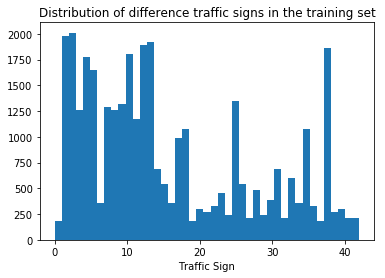

In [8]:
signs = y_train.tolist()
plt.hist(signs,bins=43)
plt.xlabel('Traffic Sign')
plt.title("Distribution of difference traffic signs in the training set")

It can be seen that various traffic sign classes do not have equal representation in the training set. In order to reduce bias in the training, we augment 
the training data set by adding various transformations to the existing images and adding them to the training pile such that there are no longer any under represented classes in the training set.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## PreProcessing - Augment the training dataset

In [9]:
copy = image.copy()

#### Adding Noise

In [10]:
def add_noise(image, mode='gaussian'):
    # for mode use gaussian or speckle
    noisy_copy = skimage.util.random_noise(image, mode=mode, seed=None, clip=True)
    return noisy_copy

In [11]:
add_noise(copy).max()

0.87588889575661355

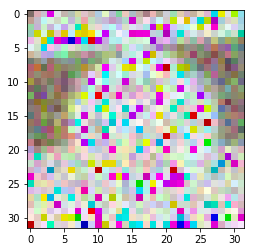

In [12]:
plt.imshow((add_noise(copy)*255).astype(np.int8))

#### Conversion to gray scale

In [13]:
from skimage import color
def to_grayscale(img):
    gry = color.rgb2gray(img)
    return np.dstack([gry, gry, gry])

In [14]:
to_grayscale(copy).max()

0.53849803921568629

#### Adding blurr

In [15]:
def add_blur(img, sigma='random', scale=True):
    """Random values should ideally be between 0.5 and 1.5"""
    if type(sigma) != str:
        out = ndimage.gaussian_filter(img, sigma=sigma)
    else:
        out = ndimage.gaussian_filter(img, sigma=random.random() + 0.5)
    if scale:
        return out.astype(np.float64)/out.max()
    else:
        return out

In [16]:
add_blur(copy).max()

1.0

#### Enhance contrast

In [17]:
from skimage.exposure import equalize_hist

In [18]:
def contrast_enhancement(img):
    #[:,:,0]
    #return skimage.exposure.equalize_hist(img)
    output = []
    for i in [0,1,2]:
        output.append(skimage.exposure.equalize_hist(img[:,:,i]))
    return np.dstack(output)

In [19]:
contrast_enhancement(copy).max()

1.0

#### Translation by small amounts in x and y direction

In [20]:
from skimage.transform import SimilarityTransform
from skimage.transform import warp

def translation(img, x_trans='random', y_trans='random'):
    if x_trans == 'random':
        x_trans = random.randint(-5, 5)
    if y_trans == 'random':
        y_trans = random.randint(-5, 5)
        
    translate = SimilarityTransform(translation=(x_trans, y_trans))
    return warp(img, translate)

In [21]:
translation(copy).max()

0.62745098039215685

### from the augmentation options, randomly choose one and apply to image

In [22]:
def run_random_function(img):
    aug_options = [add_noise, to_grayscale, add_blur, contrast_enhancement, translation]
    func = aug_options[random.randint(0, len(aug_options) - 1)]
    return func(img)

### how many augmentations are needed per lable such that are labels have the same number of training samples

In [23]:
x = pd.Series(y_train).value_counts()
xmax = x[:1].values[0]
rows = []
for i in zip(x.index, x):
    v = (i[0], i[1], xmax - i[1])
    rows.append(v)

In [24]:
counts_df = pd.DataFrame(rows, columns=['label', 'count', 'to_add'])
counts_df

,label,count,to_add
0,2,2010,0
1,1,1980,30
2,13,1920,90
3,12,1890,120
4,38,1860,150
5,10,1800,210
6,4,1770,240
7,5,1650,360
8,25,1350,660
9,9,1320,690


### Apply the augmentation

In [25]:
x_extra_train = []
y_extra_train = []

for _, row in counts_df.iterrows():
    spec_x = X_train[y_train == row.label]
    i2add = np.random.randint(0, len(spec_x)-1, size=row.to_add)
    if len(spec_x[i2add]):
        for img in spec_x[i2add]:
            transformed = run_random_function(img)

            x_extra_train.append(transformed)
            y_extra_train.append(row.label)
    print("Lebel {} completed: {} images added.".format(row.label, row.to_add))

Lebel 2 completed: 0 images added.
Lebel 1 completed: 30 images added.
Lebel 13 completed: 90 images added.
Lebel 12 completed: 120 images added.
Lebel 38 completed: 150 images added.
Lebel 10 completed: 210 images added.
Lebel 4 completed: 240 images added.
Lebel 5 completed: 360 images added.
Lebel 25 completed: 660 images added.
Lebel 9 completed: 690 images added.
Lebel 7 completed: 720 images added.
Lebel 8 completed: 750 images added.
Lebel 3 completed: 750 images added.
Lebel 11 completed: 840 images added.
Lebel 18 completed: 930 images added.
Lebel 35 completed: 930 images added.
Lebel 17 completed: 1020 images added.
Lebel 31 completed: 1320 images added.
Lebel 14 completed: 1320 images added.
Lebel 33 completed: 1411 images added.
Lebel 15 completed: 1470 images added.
Lebel 26 completed: 1470 images added.
Lebel 28 completed: 1530 images added.
Lebel 23 completed: 1560 images added.
Lebel 30 completed: 1620 images added.
Lebel 34 completed: 1650 images added.
Lebel 6 comple

### normalize original training dataset -- since the augmented ones are have values between 0-1

In [26]:
X_train_orig = X_train.astype(np.float64)/255

In [27]:
# number of original training dataset
X_train_orig.shape

(34799, 32, 32, 3)

In [28]:
# put all additional augmented training samples into an array
x_extra_train_array = np.array(x_extra_train)

In [29]:
# number of the additional training dataset
x_extra_train_array.shape

(51631, 32, 32, 3)

In [30]:
# add the augmented training dataset images and labels to the original set
X_comb = np.concatenate((X_train_orig, x_extra_train_array))
y_comb = np.concatenate((y_train, np.array(y_extra_train)))

In [31]:
y_train.shape, np.array(y_extra_train).shape

((34799,), (51631,))

In [32]:
# size of the total sample = size of original sample + size of the augmented data
X_comb.shape[0] == X_train_orig.shape[0] + x_extra_train_array.shape[0] 

True

### subtract mean

In [33]:
# mean of the training dataset
X_comb_mean = X_comb.mean()

In [34]:
# subtract mean of training dataset from training dataset
X_comb = X_comb - X_comb_mean

In [35]:
# normalize validation data set
# subtract mean of training dataset from validation dataset
X_valid = (X_valid.astype(np.float64)/255)
X_valid = X_valid-X_comb_mean

### shuffle

In [36]:
from sklearn.utils import shuffle
X_train = X_comb
y_train = y_comb
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [37]:

tf.reset_default_graph()

In [38]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [39]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    
    filter1_weight = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    # out_H = (in_H - F_H+1)/stride
    #out_D = F_D
    
    filter1_bias = tf.Variable(tf.zeros(6))
    convolution1_w   = tf.nn.conv2d(x, filter1_weight, strides=[1, 1, 1, 1], padding='VALID') 
    convolution1= tf.nn.bias_add(convolution1_w, filter1_bias)
    
    # TODO: Activation.
    activation1 = tf.nn.relu(convolution1)
    
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pooling1 = tf.nn.max_pool(activation1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    
    filter2_weight = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    filter2_bias = tf.Variable(tf.zeros(16))
    convolution2_w   = tf.nn.conv2d(pooling1, filter2_weight, strides=[1, 1, 1, 1], padding='VALID') 
    convolution2= tf.nn.bias_add(convolution2_w, filter2_bias)
    
    # TODO: Activation.
    activation2 = tf.nn.relu(convolution2)
    
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pooling2 = tf.nn.max_pool(activation2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flat   = flatten(pooling2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    FC1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    FC1_b = tf.Variable(tf.zeros(120))
    FC1   = tf.matmul(flat, FC1_w) + FC1_b
    
    # TODO: Activation.
    activation3 = tf.nn.relu(FC1)
    
    
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    FC2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    FC2_b = tf.Variable(tf.zeros(84))
    FC2   = tf.matmul(activation3, FC2_w) + FC2_b
    
    
    
    # TODO: Activation.
    activation4 = tf.nn.relu(FC2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    FC3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    FC3_b = tf.Variable(tf.zeros(43))
    logits   = tf.matmul(activation4, FC3_w) + FC3_b
    
    #return FC2_w, FC3_w, logits
    return logits

In [40]:
import tensorflow as tf
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [41]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Train the model

In [42]:
EPOCHS = 24
BATCH_SIZE = 64

In [43]:
# 0.001
rate = 0.001
logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [44]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [45]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print()
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.881

EPOCH 1 ...
Validation Accuracy = 0.854

EPOCH 2 ...
Training Accuracy = 0.941

EPOCH 2 ...
Validation Accuracy = 0.892

EPOCH 3 ...
Training Accuracy = 0.954

EPOCH 3 ...
Validation Accuracy = 0.905

EPOCH 4 ...
Training Accuracy = 0.967

EPOCH 4 ...
Validation Accuracy = 0.917

EPOCH 5 ...
Training Accuracy = 0.971

EPOCH 5 ...
Validation Accuracy = 0.925

EPOCH 6 ...
Training Accuracy = 0.978

EPOCH 6 ...
Validation Accuracy = 0.934

EPOCH 7 ...
Training Accuracy = 0.977

EPOCH 7 ...
Validation Accuracy = 0.915

EPOCH 8 ...
Training Accuracy = 0.981

EPOCH 8 ...
Validation Accuracy = 0.931

EPOCH 9 ...
Training Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.942

EPOCH 10 ...
Training Accuracy = 0.985

EPOCH 10 ...
Validation Accuracy = 0.939

EPOCH 11 ...
Training Accuracy = 0.984

EPOCH 11 ...
Validation Accuracy = 0.927

EPOCH 12 ...
Training Accuracy = 0.987

EPOCH 12 ...
Validation Accuracy = 0.928

EPOCH 13 ...
Training

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [46]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [47]:
from skimage import io
from skimage.transform import resize

#### load 5 examples found from the web

In [48]:
#test_files = ['no_entry.jpg', 'construction.png', 'general_caution.png', 'general_caution_snow.png', 'round_about.png', 'yield.png','turn_right.png','speed_limit_120.jpg', 'wild-animals.jpg']

In [49]:
test_files = ['no_entry.jpg', 'construction.png', 'general_caution.png',  'round_about.png', 'yield.png','speed_limit_120.jpg', 'wild-animals.jpg']

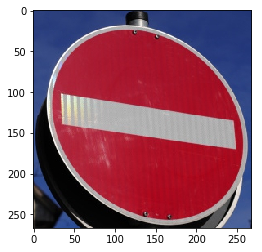

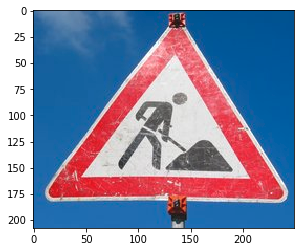

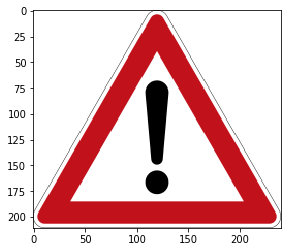

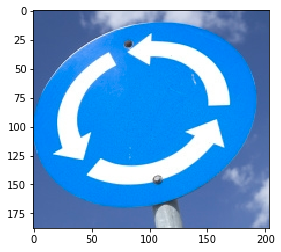

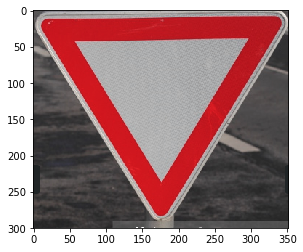

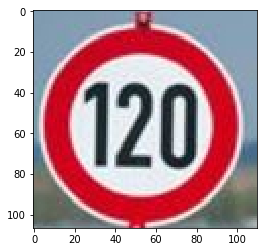

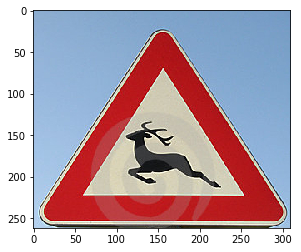

In [50]:
file_path = './german_traffic_signs/'
im_list = []
for image_name in test_files:
    im = io.imread(file_path+image_name)
    im_list.append(im)
    plt.imshow(im)
    plt.show()

#### resize the images to 32x32 and subtract training sample mean from them

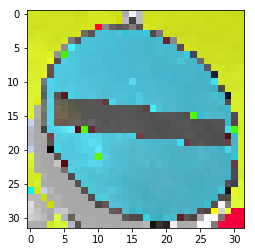

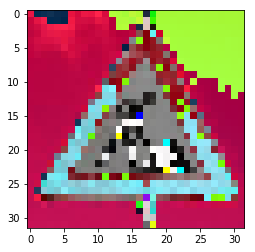

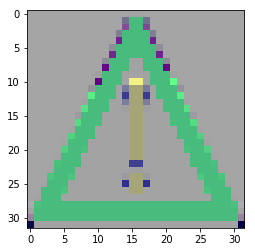

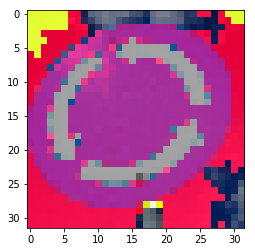

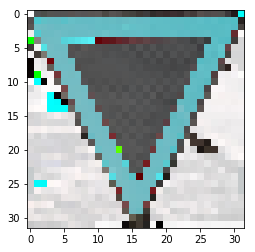

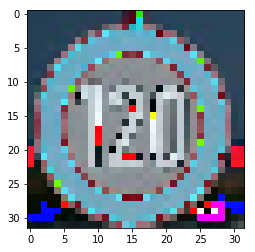

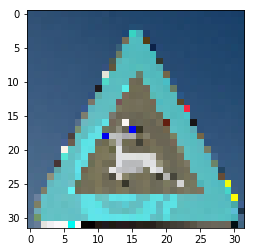

In [51]:
im_list_resized = []
for image in im_list: 
    im_resize = np.array([resize(image,(32,32,3))])
    im_resize = im_resize.astype(np.float32)-X_comb_mean
    im_list_resized.append(im_resize)
    #print(im_resize.shape)
    plt.imshow(im_resize[0])
    plt.show()

### Predict the Sign Type for Each Image

In [52]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [53]:
# use the network to predict the class of a given test image
get_class = tf.argmax(logits,1)

In [54]:
truth = ['No entry', 'Road work', 'General caution', 'Roundabout mandatory', 'Yield', 'Speed limit (120km/h)', 'Wild animals crossing']

In [55]:
print("Truth = ", truth)
# make prediction
prediction =[]
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./lenet')
    for im_resize in im_list_resized:
        cl = sess.run(get_class, feed_dict={x:im_resize})
        prediction.append(names_df[names_df["ClassId"]==cl[0]].SignName.values[0])
    print("Prediction = ",prediction)
        

Truth =  ['No entry', 'Road work', 'General caution', 'Roundabout mandatory', 'Yield', 'Speed limit (120km/h)', 'Wild animals crossing']
Prediction =  ['No entry', 'Road work', 'General caution', 'Roundabout mandatory', 'Yield', 'Speed limit (20km/h)', 'Beware of ice/snow']


### Analyze Performance

In [56]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [57]:
ac = 0
for i in range(len(truth)):
    if truth[i] == prediction[i]:
          ac += 1
print('Prediction accuracy for the test images is: %', round(float(ac)*100/len(truth),2))          

Prediction accuracy for the test images is: % 71.43


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

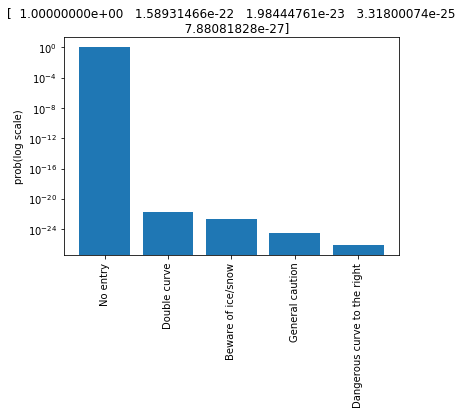

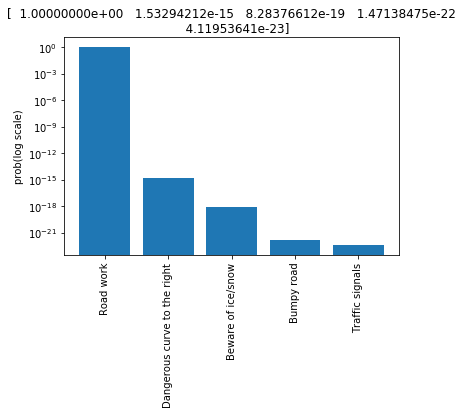

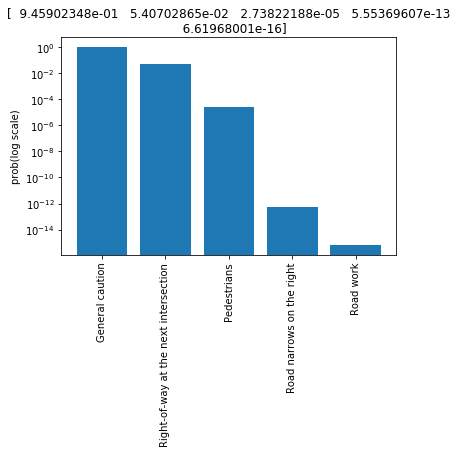

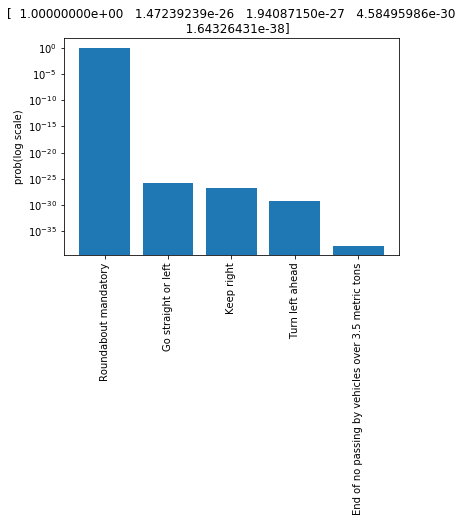

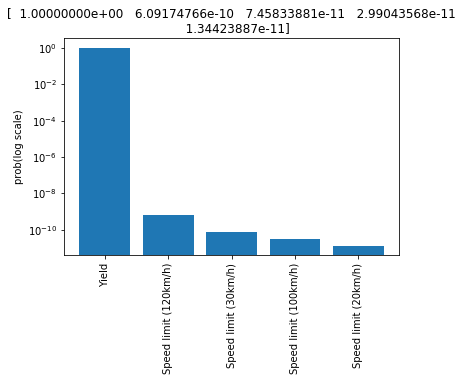

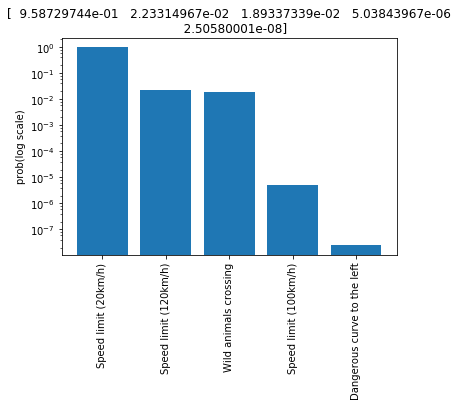

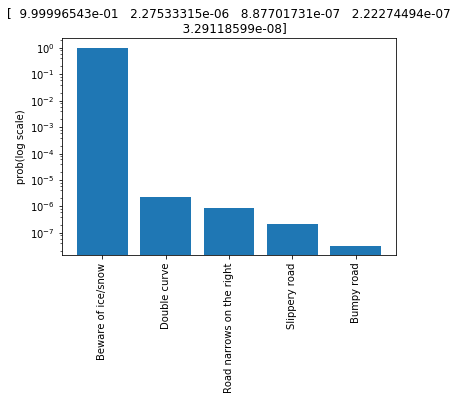

In [58]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess,'./lenet')
    for im_resize in im_list_resized:
    
        
        top_5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x:im_resize}) 
        x_ticks = [names_df[names_df["ClassId"]==x].SignName.values[0] for x in top_5.indices[0]]
        fig,ax = plt.subplots(1,1)
        ax.bar(range(5),top_5.values[0])
        ax.set_yscale('log')
        ax.set_xticks(range(5))
        ax.set_ylabel("prob(log scale)")
        ax.set_title(top_5.values[0])
        _ = ax.set_xticklabels(x_ticks,rotation=90)
        

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [59]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [60]:
mu = 0
sigma = 0.1

# TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.

filter1_weight = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
# out_H = (in_H - F_H+1)/stride
#out_D = F_D

filter1_bias = tf.Variable(tf.zeros(6))
convolution1_w   = tf.nn.conv2d(im_resize, filter1_weight, strides=[1, 1, 1, 1], padding='VALID') 
convolution1= tf.nn.bias_add(convolution1_w, filter1_bias)

# TODO: Activation.
activation1 = tf.nn.relu(convolution1)


# TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
pooling1 = tf.nn.max_pool(activation1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# TODO: Layer 2: Convolutional. Output = 10x10x16.

filter2_weight = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
filter2_bias = tf.Variable(tf.zeros(16))
convolution2_w   = tf.nn.conv2d(pooling1, filter2_weight, strides=[1, 1, 1, 1], padding='VALID') 
convolution2= tf.nn.bias_add(convolution2_w, filter2_bias)

# TODO: Activation.
activation2 = tf.nn.relu(convolution2)


# TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
pooling2 = tf.nn.max_pool(activation2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# TODO: Flatten. Input = 5x5x16. Output = 400.
flat   = flatten(pooling2)

# TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
FC1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
FC1_b = tf.Variable(tf.zeros(120))
FC1   = tf.matmul(flat, FC1_w) + FC1_b

# TODO: Activation.
activation3 = tf.nn.relu(FC1)



# TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
FC2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
FC2_b = tf.Variable(tf.zeros(84))
FC2   = tf.matmul(activation3, FC2_w) + FC2_b



# TODO: Activation.
activation4 = tf.nn.relu(FC2)

# TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
FC3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
FC3_b = tf.Variable(tf.zeros(43))
logits   = tf.matmul(activation4, FC3_w) + FC3_b


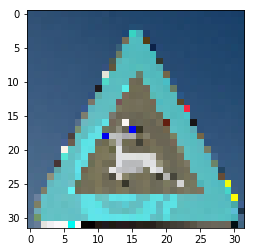

In [61]:
plt.imshow(im_resize[0])

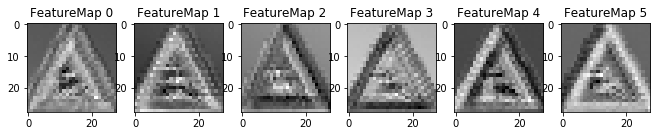

In [62]:
# convolution1 layer
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./lenet')
    outputFeatureMap(im_resize, convolution1,  activation_min=-1, activation_max=-1 ,plt_num=1)

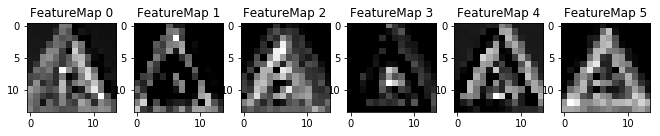

In [63]:
# pooling1 layer
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./lenet')
    outputFeatureMap(im_resize, pooling1,  activation_min=-1, activation_max=-1 ,plt_num=1)

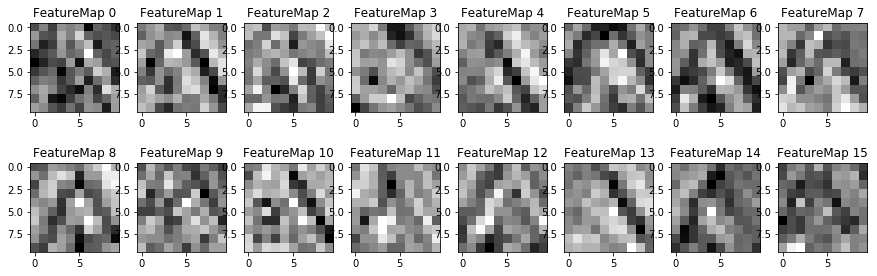

In [64]:
# convolution2 layer
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./lenet')
    outputFeatureMap(im_resize, convolution2 , activation_min=-1, activation_max=-1 ,plt_num=1)

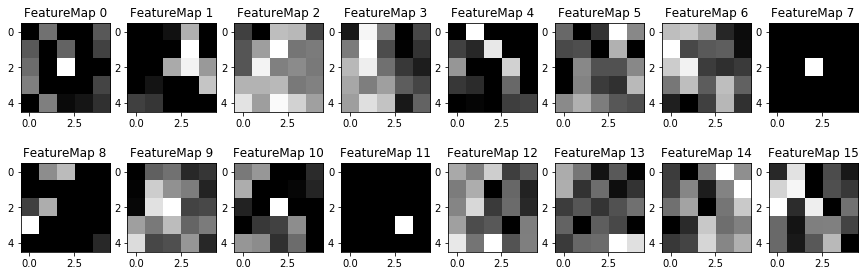

In [65]:
# pooling2 layer
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./lenet')
    outputFeatureMap(im_resize, pooling2 , activation_min=-1, activation_max=-1 ,plt_num=1)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:** 
Here I look into visualization of features at some of the layers for an test case where the network failed to classify the image correctly (wild animals crossing).
Looking at the second convolution layer, it can be seen that the shape of the sign (triangular) shape is picked up by the network nicely. However the marking in the middle seems
to be lost and as a result the network is predicting 'Beware of ice/snow'. This particular image had a water mark on it originally and I wonder if that contributes to the issue.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 